In [7]:
import spotipy
import time
import joblib
import pandas as pd
import numpy as np
import scipy.stats as spst
from sklearn.cluster import KMeans

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
import oauth2

client_credentials_manager = spotipy.oauth2.SpotifyClientCredentials(client_id = 'hidden_client_id',
                                                     client_secret = 'hidden_secret')

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

AttributeError: module 'spotipy' has no attribute 'oauth2'

In [7]:
def get_artist_id_from_name(name):
    results = sp.search(q='artist:' + name, type='artist', limit = 1)
    return name, results['artists']['items'][0]['id']

def get_artist_name_from_id(artist_id):
    results = sp.artist(artist_id)
    return results.items()[1][1]


def get_artists_from_playlist(creator, playlist_uri):
    results = sp.user_playlist(creator, playlist_uri, fields = "tracks, next")
    
    track_names = [x['track']['name'] if x['track'] else None for x in results['tracks']['items']]
    track_names = [x for x in track_names if x is not None]
    
    artist_names = [x['track']['artists'][0]['name'] if x['track'] else None for x in results['tracks']['items']]
    artist_names = [x for x in artist_names if x is not None]
    
    artist_uri = [x['track']['artists'][0]['uri'] if x['track'] else None for x in results['tracks']['items']]
    artist_uri = [x for x in artist_uri if x is not None]
    
    return zip(artist_names, artist_uri)


def get_top_tracks_data_from_artist_uri(artist_uri):
    results = sp.artist_top_tracks(artist_uri)
    
    uris = [x['uri'] for x in results['tracks']]
    names = [x['name'] for x in results['tracks']]
    
    return zip(names, uris)


def get_artist_popularity(artist_id):
    data = sp.artist(artist_id)
    popularity = data['popularity']
    return popularity



def audio_features_from_track_uri(track_uri, relevant_features = ['energy', 'liveness', 'speechiness', 'acousticness',
                                                      'instrumentalness', 'time_signature', 'danceability', 
                                                      'key', 'loudness', 'valence', 'tempo']
                                ):
    audio_features_data = sp.audio_features(tracks = [track_uri])
    relevant_features = pull_relevant_audio_features(audio_features_data[0], relevant_features)
    
    return relevant_features


def pull_relevant_audio_features(features_list,
                                 relevant_features = ['energy', 'liveness', 'speechiness', 'acousticness',
                                                      'instrumentalness', 'time_signature', 'danceability', 
                                                      'key', 'loudness', 'valence', 'tempo']
                                ):
    
    
    feat_pair = []
    for feat in relevant_features:
        feat_pair.append( (feat, features_list[feat]) )
    return feat_pair



def creat_artist_feature_dataframe(artist_uri):
    artist_tracks_data = get_top_tracks_data_from_artist_uri(artist_uri)
    uri_list = [data for name, data in artist_tracks_data]
    name_list = [name for name, data in artist_tracks_data]
    
    artist_top_track_audio_data = zip(
        [x[0] for x in artist_tracks_data],
        [audio_features_from_track_uri(x[1]) for x in artist_tracks_data]
    )
    
    audio_feature_df = pd.DataFrame([dict(data) for name, data in artist_top_track_audio_data])
    audio_feature_df_with_uri = pd.concat(
        [audio_feature_df,
         pd.Series(uri_list).rename('track_uri'),
         pd.Series(name_list).rename('track_name')
        ],
        axis = 1
    )
    
    return audio_feature_df_with_uri


def tempo_scale(x):
    return (x - 40) / (200 - 40)

def loudness_scale(x):
    return (x - -60) / (0 - -60)


def cluster_tightness_metric(dataframe, cluster_center_array):
    return np.sum(np.sum((dataframe.as_matrix() - cluster_center_array)**2, axis = 1))



# evaluate any given artist by name
def evaluate_artist_by_name_top_tracks(artist_name):
    artist_tup = get_artist_id_from_name(artist_name)
    
    artist_df = creat_artist_feature_dataframe(artist_tup[1])
    
    key_features = ['acousticness', 'danceability', 'energy', 'valence',
                'instrumentalness', 'loudness_scaled', 'speechiness', 'tempo_scaled']
    
    relevant = artist_df.copy()
    relevant['loudness_scaled'] = relevant.loudness.apply(loudness_scale)
    relevant['tempo_scaled'] = relevant.tempo.apply(tempo_scale)
    
    km = KMeans(n_clusters=1)
    km.fit(relevant[key_features])
    center_coordinates = km.cluster_centers_# same as np.mean(relevant[key_features], axis = 0)
    
    cluster_tightness = cluster_tightness_metric(relevant[key_features], center_coordinates)
    
    return artist_tup[0], cluster_tightness, artist_tup[1]



# evaluate all artists in a playlist
def evaluate_artists_in_playlist(playlist_owner, playlist_uri):
    
    # get artists from playlist
    artists_in_playlist_data = get_artists_from_playlist(playlist_owner, playlist_uri)
    
    # get artist top tracks and create dictionary
    artists_feature_dfs = dict()
    
    for artist, uri in artists_in_playlist_data:
        
        # only evaluate artists above a popularity threshold of 60
        threshold = 60
        popularity = get_artist_popularity(uri)
        if popularity < threshold:
            print '{0} not popular enough'.format(repr(artist))
            continue
            
        if artist not in artists_feature_dfs:
            print artist
            df = creat_artist_feature_dataframe(uri)
            
            # don't keep artists with fewer than 10 top hits
            if df.shape[0] < 10:
                continue
                
            artists_feature_dfs[artist] = df
            
            time.sleep(2)
            
        else:
            print 'Already created dataframe for {0}'.format(repr(artist))
            
    
    # evaluate artists in playlist
    key_features = ['acousticness', 'danceability', 'energy','valence',
                'instrumentalness', 'loudness_scaled', 'speechiness', 'tempo_scaled']

    artist_score_list = []
    
    for key, value in artists_feature_dfs.items():

        if value.empty:
            continue

        relevant = value.copy()

        relevant['loudness_scaled'] = relevant.loudness.apply(loudness_scale)
        relevant['tempo_scaled'] = relevant.tempo.apply(tempo_scale)

        km = KMeans(n_clusters=1)
        km.fit(relevant[key_features])
        center_coordinates = km.cluster_centers_ # same as np.mean(relevant[key_features], axis = 0)

        cluster_tightness = cluster_tightness_metric(relevant[key_features], center_coordinates)

        artist_score_list.append((key, cluster_tightness))

    artist_score_list.sort(key = lambda x: x[1])
    
    return artists_feature_dfs, artist_score_list

If you're like me, when you listen to music, you sometimes catch yourself thinking, "This band is so one-dimensional. All of their songs sound the same!"

When I had this experience again last week, I finally decided to find out whether anyone had ever written about this / tried to actually quantify this concept. I found tons of [websites](http://www.watchmojo.com/mobile/id/12804/) and [discussions](https://www.reddit.com/r/Music/comments/3qu62n/what_band_sounds_the_same_on_almost_every_song/) listing [bands](https://www.thetoptens.com/bands-who-songs-all-sound-same/) that [authors](http://www.gamespot.com/forums/offtopic-discussion-314159273/bands-whos-songs-all-sound-the-same-26510911/) think are one-dimensional, but it seemed like **nobody had actually tried to quantify it.**

This post is my stab at doing just that. Using math and data gathered from the Spotify API, I'm going to try to answer the question of which artists are the most one-dimensional. I'm only going to use an artist's top 10 tracks to represent their "sound". So really, I'm measuring which artist's top hits are the most one-dimensional.

Ideally, I'd use their entire discography. But the time required to filter and clean that data from Spotify is massive, so this will have to do.

Before I get started with the Spotify data, though, I need to define one-dimensionality in some kind of mathematical way.

If you don't care about the math or the data and just want to see the results, skip to the **Ranking the Spotify Global Top Artists of 2012-2016** section at the bottom.

# Defining One-Dimensionality

When I say an artist is one-dimensional, I'm really saying that the characteristics of their songs are all really similar. There's very little variety in their sound. The goal is to represent this concept mathematically so I can actually quantify how similar an artist's songs are.

To do that, I'll try to capture how close together these songs are in some K-dimensional vector space defined by the number of song characteristics I think impact how I perceive the sound (or in this case, the number of relevant characteristics Spotify gives me access to).

Within that mathematical framework, I can represent each song as a vector and calculate how tightly packed together an artist's songs are.

Sounds good in the abstract, but I need to get more specific.

### Cluster Spread

I'll define an artist's **cluster spread** as the sum of the squared distances of a given song vector to the center of all the song vectors, summed over every song. Any definition of distance will have its own issues, but this seems like a pretty good way to measure how spread out a cluster is since:

1. If all song features range from 0 to 1, the squared distance reduces the impact of any individual song.
2. I'm using the top 10 tracks for every artist, making a summation-based metric comparable across artists.

Mathematically, $$CS = \sum_{i=1}^{10}\sum_{i=1}^{k}(x_{i} - c)^{2}$$

This can be a little confusing. It's easier to get an intution of this metric visually, by looking at two made-up examples.

In the plots below, the red X represents the center of each cluster of three points. I've connected them into a triangle to really draw attention to how one group of points is more tighly knit than the other.

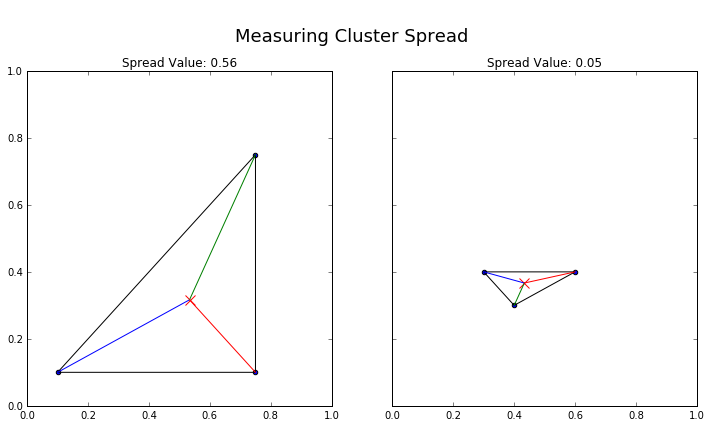

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharey=True, sharex=True)

sup_title =f.suptitle('\nMeasuring Cluster Spread', y=1.05, fontsize=18)


# Spread out cluster
data = np.array([[.1, .1],
                [.75, .75],
                [.75, .1]])

center = np.mean(data, axis = 0)
left_cluster_spread_metric = np.round(cluster_tightness_metric(pd.DataFrame(data), center), 2)

ax1.set_title('Spread Value: {0}'.format(left_cluster_spread_metric))
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])

ax1.scatter(data[:, 0], data[:, 1])

r = matplotlib.patches.Polygon(data, closed = True, fill=False)
ax1.add_artist(r)
ax1.scatter(center[0], center[1], c='r', s=100, marker='x')

p1 = np.vstack([center, data[0]])
ax1.plot(p1[:, 0], p1[:, 1])

p2 = np.vstack([center, data[1]])
ax1.plot(p2[:, 0], p2[:, 1])

p3 = np.vstack([center, data[2]])
ax1.plot(p3[:, 0], p3[:, 1])



# Tightly packed cluster
data = np.array([[.3, .4],
                [.4, .3],
                [.6, .4]])

center = np.mean(data, axis = 0)
right_cluster_spread_metric = np.round(cluster_tightness_metric(pd.DataFrame(data), center), 2)

ax2.set_title('Spread Value: {0}'.format(right_cluster_spread_metric))
ax2.scatter(data[:, 0], data[:, 1])

r = matplotlib.patches.Polygon(data, closed = True, fill=False)
ax2.add_artist(r)
ax2.scatter(center[0], center[1], c='r', s=100, marker='x')

p1 = np.vstack([center, data[0]])
ax2.plot(p1[:, 0], p1[:, 1])

p2 = np.vstack([center, data[1]])
ax2.plot(p2[:, 0], p2[:, 1])

p3 = np.vstack([center, data[2]])
ax2.plot(p3[:, 0], p3[:, 1])

f.savefig('/users/nickbecker/Python_Projects/cluster_spread_example.png', dpi=f.dpi, bbox_inches='tight',bbox_extra_artists=[sup_title])

It's pretty clear that the cluster of points on the right are more tightly packed than the cluster of points on the left, and the distance metric I created reflects this. The right group's Cluster Spread Value is roughly 11 times smaller than the left one, which makes sense.

It's easy to see how this works in two dimensions. While I can't visualize how this works in eight dimensions, the logic extends perfectly. I can use my Cluster Spread metric to measure any the spread of any set of points in 8-D space just like I did in the 2-D space above.

With the math taken care of, it's time to move on to the music.

# Spotify Audio Features Data

The [Spotify API](https://developer.spotify.com/web-api/) is awesome. Most importantly, for this project, Spotify provides access to [audio features](https://developer.spotify.com/web-api/get-audio-features/) for any song in their collection. Audio features are characteristics of songs like danceability, energy, and loudness that Spotify has assigned numerical values to represent.

I decided to use eight of the features. I picked ones that naturally lend themselves to a being ranked numerically (so I didn't use things like the key and time signature, but did include things like how acoustic the song is). The eight characteristics I chose are:

1. Acousticness
2. Danceability
3. Energy
4. Valence (a measure of the song's positiveness (happiness, cheerfulness, etc.))
5. Instrumentalness
6. Loudness
7. Speechiness
8. Tempo

With these features, I can represent each song as an 8-dimensional vector. I did a little bit of data transformation to scale all the features to between 0 and 1, since I don't want any one feature to dominate the spread metric.

And that's all there is to it. With my Cluster Spread formula, my features chosen, and the data from Spotify's API, I'm ready to start ranking artists.


# Ranking the Spotify Global Top Artists of 2012-2016

At the end of every year from 2012 to 2016, Spotify released a playlist of their [Global Top 100 Tracks of the Year](https://open.spotify.com/user/spotifyyearinmusic/playlist/2xKlsGov0EC2fhl6uXDgWZ). There are several hundred artists featured on these playlists, and I ranked all of the artists above a baseline popularity threshold.

In total, I ranked about 200 artists. The 10 most one-dimensional artists with top hits from 2012-2016 are:



| Rank	 | Artist            | Cluster Spread Value |
| :---:  |:-----------------:| :-------------------:|
| 1      | Kesha             | 1.72                 |
| 2      | Foster The People | 1.86                 |
| 3      | Fall Out Boy      | 1.93                 |
| 4      | American Authors  | 1.94                 |
| 5      | PSY               | 1.95                 |
| 6      | DNCE              | 1.98                 |
| 7      | Carly Rae Jepsen  | 1.99                 |
| 8      | Alesso            | 2.03                 |
| 9      | WALK THE MOON     | 2.03                 |
| 10     | Robin Schulz      | 2.07                 |


These look pretty good to me! Artists like Kesha, PSY, and Carly Rae Jepsen are classic examples of one-dimensional bands you might have picked before reading this.

While I won't say this is **the** definitive ranking, and I chose the audio features compeltely subjectively, I think this is the best anyone has done so far.

# Kesha Wins Most One-Dimensional of All Time

After ranking from the 2012-2016 Top 100 Tracks playlists, I wanted to expand back in time.

I didn't calculate Cluster Spread for every major group in history, but I did try a lot of bands (at least another 75-100). In a shocking turn of a events, Kesha managed to narrowly beat out Creed (a heavy favorite going into this process) as the most one-dimensional of all time.

But don't worry Creed fans. There's always a chance they'll come out of retirement and write a new hit that will [take them higher](https://www.youtube.com/watch?v=DhAFbwoaH7o).



---

For those interested in recreating or extending this analysis, you can access the code in a Jupyter Notebook [here](https://github.com/beckernick/artist_one_dimensionality).